<div style="background: linear-gradient(to right, #4b6cb7, #182848); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GAICo: GenAI Results Comparator</h1>
    <p style="color: #e0e0e0; margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">Example: Election</p>
</div>
<br>

This notebook demonstrates an example of using the **GAICo (GenAI Results Comparator)** library on the election domain.

Data is taken from [On safe and usable chatbots for promoting voter participation](https://onlinelibrary.wiley.com/doi/full/10.1002/aaai.12109).

Author: Bharath Muppasani

**Scenario:**

1.  **Inputs:** Responses from different models, to various questions related to election.
2.  **Metrics:** We'll use the Jaccard metric from the GAICo package.
3.  **Workflow:**
    - Calculate the metric score for the model's response against the reference.
    - Generate a CSV report summarizing the results.
    - Visualize the scores with a bar plot.


## Environment Setup & Imports

The cell below adjusts `sys.path` to find the gaico module if run from examples directory.
This block is primarily for local execution from the `examples/` folder if gaico is not installed.

In Colab however, after pip install, gaico should be importable directly.

In [1]:
# To import `gaico` from the project root, we need to ensure the path is set correctly.
# If this script is run as a standalone file, it will add the project root to the system path.

import sys
import os

notebook_dir = os.getcwd()  # Get the current working directory of the notebook
# Construct the path to the project root (one level up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")

In [2]:
import matplotlib.pyplot as plt  # For plotting
import pandas as pd

# GAICo library imports
from gaico.metrics import JaccardSimilarity  # The chosen metric
from gaico import (
    apply_thresholds,  # For applying pass/fail thresholds
    plot_metric_comparison,  # For bar plot visualization
    generate_deltas_frame,  # For creating a CSV report
)


print("GAICo and necessary libraries imported.")

GAICo and necessary libraries imported.


## Define Inputs: LLM Responses and Reference

In [3]:
# Load the Excel file
file_path = os.path.join("data", "election", "SC-Election-Data-April2022-AI-Comparison.csv")
df = pd.read_csv(file_path)

# Display preview
df[["Question", "Answer", "ChatGPT-4o", "Gemini 2.5 Flash"]].head()

,Question,Answer,ChatGPT-4o,Gemini 2.5 Flash
0,It is past the voter registration deadline and...,If you\n\n\n\nmoved to another residence withi...,"No, you typically cannot vote if you're not re...","Generally, no. Registration deadlines are strict."
1,"What offices, candidates and questions are on ...","The offices, candidates and questions on a par...",NaN,Check your state or local election office webs...
2,How and where can I vote early in person?,Visit an early voting center in your county du...,Usually at designated early voting sites liste...,Check with your state or local election office...
3,Who can vote absentee?,State law allows voters with qualifying reason...,"Request a ballot, fill it out, and return it b...",Eligibility varies by state; some require an e...
4,How can I vote absentee?,"Step 1: Get your application\n\nCall, visit o...","Request a ballot, fill it out, and return it b...",Request an absentee ballot from your state or ...


## Initialize and Use the Metric

We'll use `JaccardSimilarity` as our evaluation metric. We then calculate the similarity score for each LLM's response compared to our `reference_answer`. The `calculate` method conveniently handles broadcasting the single reference text against the list of generated texts.

In [4]:
# Prepare evaluation
metric_instance = JaccardSimilarity()
metric_key_name = "Jaccard"

results = []

In [5]:
for idx, row in df.iterrows():
    reference = str(row["Answer"])
    model_outputs = {
        "ChatGPT-4o": str(row.get("ChatGPT-4o", "")),
        "Gemini 2.5 Flash": str(row.get("Gemini 2.5 Flash", "")),
        "SafeChat": reference,  # treating "Answer" column as SafeChat baseline
    }

    for model, response in model_outputs.items():
        score = metric_instance.calculate([response], reference)[0]
        results.append({"Question": row["Question"], "Model": model, "Score": score})

In [6]:
# Convert to DataFrame for analysis
scores_df = pd.DataFrame(results)
scores_df.head()

,Question,Model,Score
0,It is past the voter registration deadline and...,ChatGPT-4o,0.073171
1,It is past the voter registration deadline and...,Gemini 2.5 Flash,0.025000
2,It is past the voter registration deadline and...,SafeChat,1.000000
3,"What offices, candidates and questions are on ...",ChatGPT-4o,0.000000
4,"What offices, candidates and questions are on ...",Gemini 2.5 Flash,0.050000


In [7]:
pivot_df = scores_df.pivot(index="Question", columns="Model", values="Score")
pivot_df.reset_index(inplace=True)
pivot_df.head()

Model,Question,ChatGPT-4o,Gemini 2.5 Flash,SafeChat
0,A candidate is definitely campaigning while in...,0.103448,0.146341,1.0
1,A candidate is listed more than once on my bal...,0.076923,0.073171,1.0
2,Are ballot selfies legal? Can I take a pictur...,0.028571,0.051282,1.0
3,Are there any laws about candidates posting th...,0.062500,0.096154,1.0
4,Can I take my child with me to vote?,0.095238,0.037037,1.0


## Apply Thresholds

`GAICo` allows you to apply thresholds to scores to determine a pass/fail status. We'll use the default threshold defined in the library for "Jaccard". The `apply_thresholds` function takes a list of dictionaries, where each dictionary contains the metric name and its score.

In [8]:
# Create full threshold input
threshold_input_list = [{metric_key_name: row["Score"]} for _, row in scores_df.iterrows()]

In [9]:
# Apply thresholds
thresholded_results_list = apply_thresholds(threshold_input_list)

# Add threshold results to the DataFrame
threshold_passed = [
    result[metric_key_name]["passed_threshold"] for result in thresholded_results_list
]
scores_df["Passed_Threshold"] = threshold_passed

# Preview
scores_df.head()

,Question,Model,Score,Passed_Threshold
0,It is past the voter registration deadline and...,ChatGPT-4o,0.073171,False
1,It is past the voter registration deadline and...,Gemini 2.5 Flash,0.025000,False
2,It is past the voter registration deadline and...,SafeChat,1.000000,True
3,"What offices, candidates and questions are on ...",ChatGPT-4o,0.000000,False
4,"What offices, candidates and questions are on ...",Gemini 2.5 Flash,0.050000,False


## Visualize Results

To visually compare the performance of the LLMs, we can generate a bar plot.

In [10]:
# Aggregate average score per model
results_for_df_plotting = scores_df.groupby("Model")["Score"].mean().to_dict()

In [11]:
# Format for plotting
df_results_for_plotting = (
    pd.DataFrame.from_dict(
        {model: {metric_key_name: score} for model, score in results_for_df_plotting.items()},
        orient="index",
    )
    .reset_index()
    .rename(columns={"index": "model"})
)

display(df_results_for_plotting)

,model,Jaccard
0,ChatGPT-4o,0.046952
1,Gemini 2.5 Flash,0.100999
2,SafeChat,1.000000


In [12]:
# Convert results_for_df_plotting into the correct format for GAICo plotting
df_results_for_plotting = pd.DataFrame(
    [
        {"model_name": model, "metric_name": metric_key_name, "score": score}
        for model, score in results_for_df_plotting.items()
    ]
)

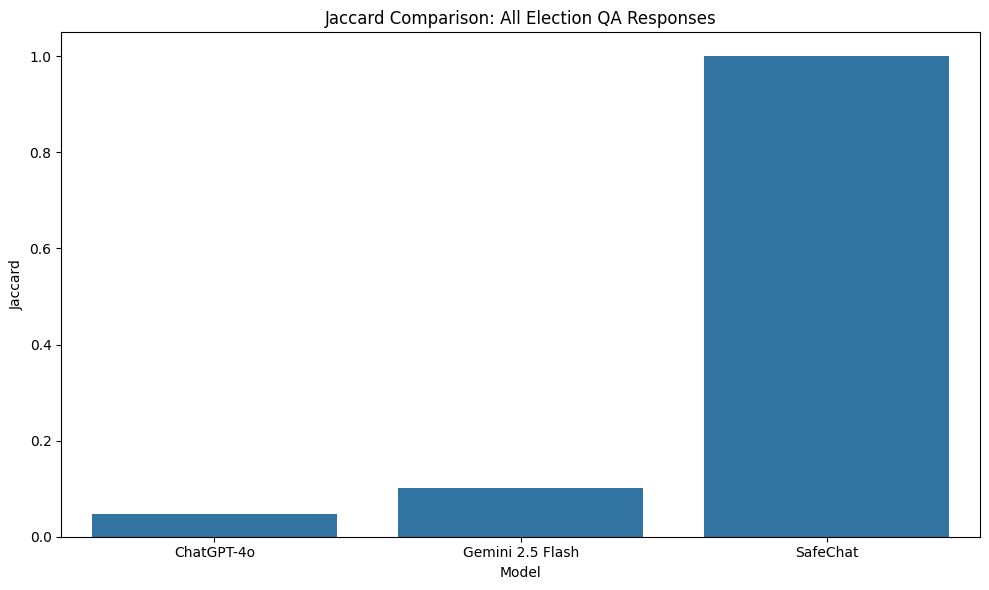

In [13]:
plot_metric_comparison(
    df_results_for_plotting,
    metric_name=metric_key_name,
    title=f"{metric_key_name} Comparison: All Election QA Responses",
)

plt.tight_layout()
plt.savefig(os.path.join("data", "election", "election_radar_plot.png"), dpi=300)

## Generate CSV Report

Finally, `GAICo` can generate a CSV report containing the generated texts, reference texts, scores, and pass/fail status. This is useful for documentation, sharing, or further analysis.

In [14]:
reference_texts_list = list(
    scores_df["Question"].map(lambda q: df[df["Question"] == q]["Answer"].values[0])
)

generated_texts_list = list(scores_df["Score"])

In [15]:
# Save CSV of results
csv_output_path = os.path.join("data", "election", "election_evaluation_table.csv")

table = generate_deltas_frame(
    threshold_results=thresholded_results_list,
    generated_texts=scores_df["Score"].tolist(),
    reference_texts=reference_texts_list,
    output_csv_path=csv_output_path,
)

CSV report generated at: data/election/election_evaluation_table.csv


In [16]:
display(table)

,generated_text,reference_text,Jaccard_score,Jaccard_passed
0,0.07317073170731707,If you\n\n\n\nmoved to another residence withi...,0.073171,False
1,0.025,If you\n\n\n\nmoved to another residence withi...,0.025000,False
2,1.0,If you\n\n\n\nmoved to another residence withi...,1.000000,True
3,0.0,"The offices, candidates and questions on a par...",0.000000,False
4,0.05,"The offices, candidates and questions on a par...",0.050000,False
...,...,...,...,...
85,0.07272727272727272,Apply to be a poll manager today. State and co...,0.072727,False
86,1.0,Apply to be a poll manager today. State and co...,1.000000,True
87,0.058823529411764705,Contact your county voter registration and ele...,0.058824,False
88,0.037037037037037035,Contact your county voter registration and ele...,0.037037,False
